<a href="https://colab.research.google.com/github/joannarashid/flu_sim/blob/additional_data_viz/scratch_refactoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from collections import Counter
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

In [3]:
class Experiment:

  def __init__(self, num_trials, pop_size, p_exposure, infection_period):
    """
    Initialize experiment parameters.

    Params:
      num_trials: Number of trials to conduct.
      pop_size: Size of population as an integer.
      p_exposure: Probability of catching the virus as a float, in range[0,1]; 
        can be a float or a 2-tuple of floats to indicate variation.
      infection_period: Amount of time in days a person is infectious;
        can be an integer or a 2-tuple of integers to indicate variation.
    """
    self._evaluate_inputs(num_trials, pop_size, p_exposure, infection_period)

  def _evaluate_inputs(self, num_trials, pop_size, 
                       p_exposure, infection_period):
    """
    Evaluate inputs into Experiment object instantiation and set them if 
    they meet the requirements.

    Params:
      num_trials: Number of trials to conduct.
      pop_size: Size of population as an integer.
      p_exposure: Probability of catching the virus as a float, in range[0,1].
      infection_period: Amount of time in days a person is infectious.

    Raise ValueError:
      raised when inputs do not meet certain variable types and properties.
    """
    if not isinstance(num_trials, int):
      raise ValueError("num_trials must be an integer!")
    if not isinstance(pop_size, int):
      raise ValueError("pop_size must be an integer!")
    if not isinstance(p_exposure, (float, tuple)):
      raise ValueError("p_exposure must be a float or tuple of two floats!")
    if isinstance(p_exposure, tuple):
      p_arr = np.array(p_exposure)
      p_exposure_truth_cond = (
          False not in set(p_arr >= 0) and 
          False not in set(p_arr <= 1) and 
          isinstance(p_arr[0], float) and 
          isinstance(p_arr[1], float) and
          p_arr[0] < p_arr[1]
      )
      if not p_exposure_truth_cond:
        msg = (
            "p_exposure must be a tuple of two floats (a,b)\n",
            "such that 0 <= a <= 1 and 0 <= b <= 1\n"
            "a < b"
        )
        raise ValueError(msg)
    if not isinstance(infection_period, (int, tuple)):
      raise ValueError("infection_period must be an int or tuple of two ints!")
    if isinstance(infection_period, tuple):
      a,b = infection_period
      infection_period_truth_cond = (
          isinstance(a, int) and
          isinstance(b, int) and 
          a < b
      )
      if not infection_period_truth_cond:
        msg = "infection_period must be a tuple of two ints (a,b) and a < b"
        raise ValueError(msg)
    self._num_trials = num_trials
    self._pop_size = pop_size
    self._p_exposure = p_exposure
    self._infection_period = infection_period

  def run_experiment(self):
    """
    Conduct experiment.

    Returns:
      2-Tuple containing Pandas Dataframes from experiment; trial data, 
        and daily infections.
    """
    start = datetime.now()
    daily_infections_counts = Counter([])
    trial_data, epidemic_lengths, max_epidemic_length = \
      self.run_trials()
    for i in range(len(trial_data)):
      daily_infections_counts += Counter(trial_data[i])
      # Make all rows same length based on max_epidemic_length.
      if epidemic_lengths[i] < max_epidemic_length: 
        trial_data[i].extend([0]*(max_epidemic_length - epidemic_lengths[i]))
      trial_data[i].append(epidemic_lengths[i])

    # Build dataframe of all the trial data
    day_columns = [f'D{i}' for i in range(1, 1+max_epidemic_length)]
    columns = day_columns + ['Epidemic_Length (Days)']
    time_elapsed = datetime.now() - start
    print(f"Total time elapsed to gather data for {self._num_trials} trials: "
          f"{time_elapsed}\n\n")
    df = pd.DataFrame(trial_data, columns=columns)
    df['Total_Infections'] = 1 + df[day_columns].sum(axis=1)

    # Build dataframe of all daily infection frequencies
    daily_infection_counts_data = {
        'Number of Daily Infections': [],
        'Frequency': []
    }
    for count in sorted(daily_infections_counts.keys()):
      daily_infection_counts_data['Number of Daily Infections'].append(count)
      daily_infection_counts_data['Frequency'].append(
          daily_infections_counts[count])
    df2 = pd.DataFrame(daily_infection_counts_data)
    df2['Percentage'] = 100*df2['Frequency']/sum(df2['Frequency'])
    return df, df2

  def run_trials(self):
    """
    Conduct all the trials.

    Returns: 3-Tuple consisting of the following
      trial_data: List of trials' metadata.
      epidemic_lengths: List of trials' epidemic lengths.
      max_epidemic_length: The longest epidemic length.
    """
    epidemic_lengths = []
    trial_data = []
    max_epidemic_length = 0
    start = datetime.now()
    # Run all the trials
    for t in range(self._num_trials):
      days, num_recovery, trial_timeseries = self.flu_bern() 
      epidemic_lengths.append(days)
      trial_data.append(trial_timeseries)
      max_epidemic_length = max(max_epidemic_length, days)
    return trial_data, epidemic_lengths, max_epidemic_length

  def _set_values(self):
    """
    Initialize infected person's values for p_exposure and infection_period.

    Returns:
      dictionary: infected person's values for p_exposure and infection_period.
    """
    if isinstance(self._p_exposure, float):
      p = self._p_exposure
    else:
      p = np.random.uniform(*self._p_exposure)
    if isinstance(self._infection_period, int):
      d = self._infection_period
    else:
      d = np.random.randint(*self._infection_period)
    return {'p': p, 'd': d}

  def flu_bern(self, verbose:bool=False):
    """
    Run bernoulli trial simulation for flu spread.

    Params:
      verbose: A boolean flag whether or not to enable debug verbose logs;
                default to False.

    Returns: 3-Tuple consisting of the following
      day: The length of the epidemic as an integer.
      total_infections: The total number of individuals in recovery.
      epidemic_timeseries: The list of daily number of infections.
    """
    # Initialize set of susceptible people.
    susceptible = {i for i in range(1,self._pop_size)}

    # Randomly choose a person who initially is infected.
    first_infected = np.random.randint(1,self._pop_size)

    # Initialize infectious set and recovery set; person infectious for 3 days.

    infectious = {first_infected:self._set_values()} 
    recovery = set([])

    # Remove the first infected person from the susceptible set.
    susceptible.remove(first_infected)

    # Print this if verbose set to True
    if verbose:
      print(f"#######################Initialization#########################")
      print(f"Pr(flu exposure) = {self._p_exposure}")
      print(f"first infected person: {first_infected}")
      print(f"infectious: {infectious}")
      print(f"susceptible: {susceptible}")
      print(f"recovery: {recovery}")
      print("############################################################\n\n")

    # Initialize start of epidemic
    day = 0
    epidemic_timeseries = []

    #HL Note: we may want to add logic here to capture cases when there are 
    #multiple people infected at the beginnning of each day
    #In this case, the remaining susceptible people technically will be exposed 
    #to more interactions
    #Example: if 1 & 2 are already infected
    #3 is exposed after interacting with 1, 4 is NOT exposed after interacting 
    #with 1 but exposed after interacting with 2, etc.

    while 0 < len(infectious) <= self._pop_size:
      day += 1
      # Select the number of daily samples from Unif(0,1) 
      # equal to current number of susceptible people
      # HL note: updated logic here; each person in the susceptible set should 
      # have their own probability of getting infected each day
      sample = np.random.uniform(size=len(susceptible))

      # Each day is a series of iid Bernoulli trials
      # Each Bernoulli trial = one interaction between one infected person and 
      # one susceptible person  
      # If the sample value < p_exposure, the susceptible person becomes 
      # infected; else they remain susceptible
      
      # HL Note: update the logic here so we capture exactly who got exposed 
      # However this is slower than the original code:
      # daily_exposed = [susceptible[i] for i in range(len(susceptible)) if 
      # sample[i] < p_exposure]

      # Set daily exposed to number of remaining susceptible people if number of 
      # susceptible people is less than the daily number of infections to 
      # signify that the virus has been contracted by all members of the 
      # population.

      # Find which of the infected has the highest p_exposure
      max_p_exposure = np.max(np.array([val['p'] 
                                        for val in infectious.values()]))
      num_daily_exposed = np.sum(sample < max_p_exposure)
      
      # Add to epidemic_timeseries to track daily exposures
      epidemic_timeseries.append(num_daily_exposed)

      # Update infectious set: 
      # move people from infectious set to recovery set if they are considered 
      # no longer infectious after 3 days
      for k in infectious.keys():
        infectious[k]['d'] -= 1
        if infectious[k]['d'] == 0:
          recovery.add(k)
      infectious = {k:v for k,v in infectious.items() if v['d'] > 0}

      # Remove num_daily_exposed people from susceptible set
      # Add num_daily_exposed people to infectious sets
      for i in range(num_daily_exposed):
        k = np.random.randint(1,self._pop_size)
        while k not in susceptible: # Must select from susceptible set
          k = np.random.randint(1,self._pop_size)
        # HL Note: updated logic here so we add / remove specific people that 
        # got exposed (not here, in my own copy)
        infectious[k] = self._set_values()
        susceptible.remove(k)
      # Print this if verbose set to True
      if verbose:
        print(f"#################By end of day {day}#####################")
        print(f"sample: {sample}")
        print(f"susceptible: {susceptible}")
        print(f"Number of new exposures: {num_daily_exposed}")
        print(f"infectious: {infectious}")
        print(f"recovery: {recovery}")
        print(f"max_p_exposure: {max_p_exposure}")
        print("###########################################################\n\n")
    # Print this if verbose set to True
    if verbose:
      print(f"Epidemic length in days: {day}\n"
            f"Total infections: {len(recovery)}")
    return day, len(recovery), epidemic_timeseries


def basic_stats(df: pd.DataFrame, cols: list):
  """
  Get statistics, general and grouped.

  Params:
    df: Pandas dataframe

  Return:
    n-tuple of dataframes
  """
  output = [df.describe().T]
  for col in cols:
    output.append(df.groupby(col)[col].count())
  return tuple(output)

## Test of Sample Output

In [4]:
experiment = Experiment(10,21,0.02,3)
experiment.flu_bern(verbose=True)

#flu_bern(21, 0.02, 3, verbose=True)

#######################Initialization#########################
Pr(flu exposure) = 0.02
first infected person: 11
infectious: {11: {'p': 0.02, 'd': 3}}
susceptible: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20}
recovery: set()
############################################################


#################By end of day 1#####################
sample: [0.70558139 0.81156074 0.91032886 0.4337317  0.53799892 0.44675822
 0.23132742 0.42583578 0.35743505 0.89428904 0.64258252 0.36624033
 0.43910939 0.64562044 0.03654107 0.4937954  0.70287971 0.50729075
 0.94508869]
susceptible: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Number of new exposures: 0
infectious: {11: {'p': 0.02, 'd': 2}}
recovery: set()
max_p_exposure: 0.02
###########################################################


#################By end of day 2#####################
sample: [0.80248165 0.34178073 0.97168207 0.24013959 0.52767301 0.7884841
 0.85548222 0.34759673 0.93530168 0.7612

(9, 5, [0, 2, 1, 0, 0, 1, 0, 0, 0])

In [5]:
experiment.run_trials()

([[0, 0, 1, 1, 0, 2, 0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 1, 1, 0, 1, 0, 0, 0],
  [0, 0, 0],
  [0, 1, 0, 0, 2, 0, 0, 0],
  [0, 0, 0],
  [1, 0, 0, 1, 0, 0, 2, 0, 0, 0],
  [0, 0, 0]],
 [9, 3, 3, 3, 9, 3, 8, 3, 10, 3],
 10)

In [6]:
test_trial_df, test_dailyinfection_df = experiment.run_experiment()
test_trial_df

Total time elapsed to gather data for 10 trials: 0:00:00.004248




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,Epidemic_Length (Days),Total_Infections
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,7,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1
2,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,9,5
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1
4,1,0,1,0,0,1,1,0,1,1,0,0,0,0,0,0,13,7
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1
7,1,0,0,1,0,0,2,0,0,1,3,0,1,0,0,0,16,10
8,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,3
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1


In [7]:
test_dailyinfection_df

,Number of Daily Infections,Frequency,Percentage
0,0,46,70.769231
1,1,16,24.615385
2,2,2,3.076923
3,3,1,1.538462


In [8]:
experiment2 = Experiment(10,21,(0.01,0.1),(3,7))
experiment2.flu_bern(verbose=True)

#######################Initialization#########################
Pr(flu exposure) = (0.01, 0.1)
first infected person: 10
infectious: {10: {'p': 0.030292959963066697, 'd': 6}}
susceptible: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
recovery: set()
############################################################


#################By end of day 1#####################
sample: [0.67551494 0.46656859 0.01520538 0.20797933 0.97098617 0.21241661
 0.86817693 0.6395921  0.23840964 0.00666513 0.32736509 0.82697231
 0.89782457 0.37336753 0.87398736 0.89671354 0.91988698 0.37987256
 0.06064608]
susceptible: {1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20}
Number of new exposures: 2
infectious: {10: {'p': 0.030292959963066697, 'd': 5}, 15: {'p': 0.0462013182817959, 'd': 5}, 4: {'p': 0.03638579455827474, 'd': 5}}
recovery: set()
max_p_exposure: 0.030292959963066697
###########################################################


#################By end of day 2##########

(21, 16, [2, 0, 2, 0, 2, 2, 0, 1, 1, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [9]:
experiment2.run_trials()

([[0, 2, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0],
  [0, 0, 1, 2, 2, 2, 2, 2, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [1, 1, 1, 1, 0, 1, 3, 4, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
  [1, 1, 0, 1, 5, 0, 1, 1, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0],
  [1, 2, 0, 2, 2, 3, 1, 4, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 3, 1, 1, 2, 2, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0],
  [2, 2, 1, 1, 0, 1, 3, 1, 1, 1, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 2, 4, 0, 1, 1, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0],
  [2, 2, 3, 0, 0, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0],
  [0, 1, 0, 0, 1, 0, 0, 0]],
 [12, 18, 22, 18, 18, 23, 23, 21, 15, 8],
 23)

In [10]:
test_trial_df2, test_dailyinfection_df2 = experiment2.run_experiment()
test_trial_df2

Total time elapsed to gather data for 10 trials: 0:00:00.013064




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D19,D20,D21,D22,D23,D24,D25,D26,Epidemic_Length (Days),Total_Infections
0,3,0,2,2,2,1,1,1,0,0,...,0,0,0,0,0,0,0,0,24,17
1,1,3,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,11,8
2,0,0,2,0,1,2,0,1,0,2,...,0,0,1,0,0,0,0,0,24,16
3,3,2,0,1,0,1,1,1,4,0,...,0,0,0,0,0,0,0,0,14,14
4,0,2,1,0,0,1,1,1,2,1,...,0,1,1,1,0,0,0,0,26,17
5,2,0,1,0,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,18,11
6,0,1,2,3,0,1,2,0,2,1,...,0,0,0,0,0,0,0,0,14,13
7,3,3,1,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,22,17
8,0,0,0,0,1,1,5,1,2,0,...,1,0,0,0,0,0,0,0,25,19
9,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,3


In [11]:
test_dailyinfection_df2

,Number of Daily Infections,Frequency,Percentage
0,0,104,55.913978
1,1,52,27.956989
2,2,20,10.752688
3,3,8,4.301075
4,4,1,0.537634
5,5,1,0.537634


## Conducting the Experiment

In [12]:
base_experiment = Experiment(1000000, 21, 0.02, 3)
trial_df, daily_infections_freq_df = base_experiment.run_experiment()
trial_df.head()

Total time elapsed to gather data for 1000000 trials: 0:03:37.676658




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D31,D32,D33,D34,D35,D36,D37,D38,Epidemic_Length (Days),Total_Infections
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,4
1,1,0,0,1,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,9,6
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
4,0,0,1,2,2,0,0,2,0,1,...,0,0,0,0,0,0,0,0,17,12


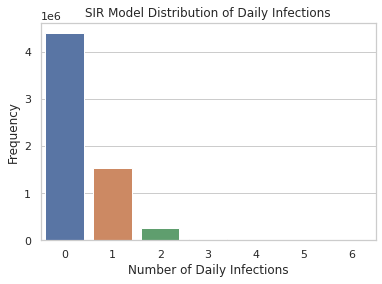

,Number of Daily Infections,Frequency,Percentage
0,0,4393165,70.848404
1,1,1525021,24.593955
2,2,253910,4.094797
3,3,26638,0.429590
4,4,1945,0.031367
5,5,115,0.001855
6,6,2,0.000032


In [13]:
sns.barplot(data = daily_infections_freq_df,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df

In [14]:
# Distribution of epidemic lengths in a trial
stats, groupby_epidemiclength, groupby_totalinfections = \
  basic_stats(trial_df, ['Epidemic_Length (Days)', 'Total_Infections'])

In [15]:
groupby_epidemiclength

Epidemic_Length (Days)
3     315848
4     108569
5     109035
6     110028
7      75846
8      63528
9      52152
10     40040
11     31510
12     24573
13     18490
14     14081
15     10504
16      7813
17      5508
18      3924
19      2794
20      1933
21      1362
22       833
23       598
24       362
25       256
26       163
27        92
28        62
29        33
30        32
31        13
32         6
33         7
34         2
35         2
38         1
Name: Epidemic_Length (Days), dtype: int64

In [16]:
# Distribution of total infections in a trial
groupby_totalinfections

Total_Infections
1     315848
2     190280
3     150389
4     111885
5      80441
6      56476
7      37792
8      24568
9      14984
10      8627
11      4599
12      2350
13      1071
14       452
15       147
16        69
17        14
18         7
19         1
Name: Total_Infections, dtype: int64

In [17]:
# Statistics per column of all the trial data
stats

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.381184,0.611311,0.0,0.0,0.0,1.0,6.0
D2,1000000.0,0.371783,0.602880,0.0,0.0,0.0,1.0,6.0
D3,1000000.0,0.365044,0.597608,0.0,0.0,0.0,1.0,5.0
D4,1000000.0,0.237836,0.509445,0.0,0.0,0.0,0.0,5.0
D5,1000000.0,0.193434,0.466617,0.0,0.0,0.0,0.0,5.0
D6,1000000.0,0.152480,0.420516,0.0,0.0,0.0,0.0,5.0
D7,1000000.0,0.112044,0.363915,0.0,0.0,0.0,0.0,5.0
D8,1000000.0,0.085282,0.319558,0.0,0.0,0.0,0.0,5.0
D9,1000000.0,0.063528,0.277352,0.0,0.0,0.0,0.0,5.0
D10,1000000.0,0.046392,0.237659,0.0,0.0,0.0,0.0,5.0


In [18]:
base_experiment2 = Experiment(1000000, 21, 0.03, 3)
trial_df2, daily_infections_freq_df2 = base_experiment2.run_experiment()
stats2, groupby_epidemiclength2, groupby_totalinfections2 = \
  basic_stats(trial_df2, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:04:40.674058




In [19]:
trial_df2.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D31,D32,D33,D34,D35,D36,D37,D38,Epidemic_Length (Days),Total_Infections
0,1,0,2,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,9,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
2,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,10,5
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,2
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,4


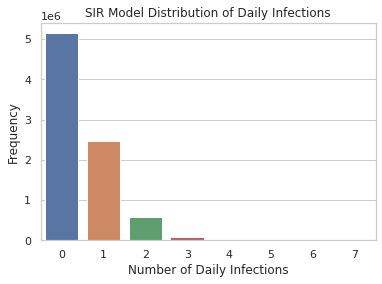

,Number of Daily Infections,Frequency,Percentage
0,0,5146869,62.093765
1,1,2466997,29.762781
2,2,577592,6.968287
3,3,87005,1.049661
4,4,9552,0.115239
5,5,793,0.009567
6,6,56,0.000676
7,7,2,0.000024


In [20]:
sns.barplot(data = daily_infections_freq_df2,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df2

In [21]:
groupby_epidemiclength2

Epidemic_Length (Days)
3     175569
4      87054
5      89248
6      92738
7      79670
8      72688
9      65905
10     57656
11     50473
12     43580
13     37131
14     31141
15     25938
16     21453
17     16903
18     13447
19     10428
20      8009
21      6127
22      4471
23      3336
24      2330
25      1642
26      1103
27       699
28       471
29       321
30       188
31       119
32        58
33        50
34        19
35        15
36        14
37         4
38         2
Name: Epidemic_Length (Days), dtype: int64

In [22]:
groupby_totalinfections2

Total_Infections
1     175569
2     118892
3     116717
4     108380
5      98595
6      87085
7      74886
8      61535
9      49234
10     37979
11     27621
12     18431
13     12026
14      6951
15      3588
16      1598
17       694
18       175
19        39
20         5
Name: Total_Infections, dtype: int64

In [23]:
stats2

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.570535,0.743836,0.0,0.0,0.0,1.0,7.0
D2,1000000.0,0.552621,0.731654,0.0,0.0,0.0,1.0,6.0
D3,1000000.0,0.538244,0.723270,0.0,0.0,0.0,1.0,6.0
D4,1000000.0,0.420856,0.668446,0.0,0.0,0.0,1.0,6.0
D5,1000000.0,0.361615,0.630947,0.0,0.0,0.0,1.0,6.0
D6,1000000.0,0.304193,0.588731,0.0,0.0,0.0,0.0,7.0
D7,1000000.0,0.248995,0.540402,0.0,0.0,0.0,0.0,6.0
D8,1000000.0,0.204685,0.495890,0.0,0.0,0.0,0.0,6.0
D9,1000000.0,0.165685,0.449597,0.0,0.0,0.0,0.0,5.0
D10,1000000.0,0.132666,0.405070,0.0,0.0,0.0,0.0,6.0


## Data Viz

In [24]:
#!pip install -U matplotlib

In [25]:
def long(df, pop_size):
  """
  This function takes the output df from run_experiment()
  and cleans and transforms data for epidimiological graphing.
  The df is melted to a long form on the variables, simulation and day.
  Additional variable created include cummulative totals for infections, 
  recovered agents, and susceptible agents.

  Params:
    df: Pandas dataframe,
    pop_size: Size of population as an integer.

  Returns: 
    Pandas dataframe melted and transformed.
  """
  #cleaning original df
  long_df = df.copy()
  long_df.drop(columns=long_df.columns[-2:], axis=1,  inplace=True)
  long_df.reset_index(inplace=True)

  #creating simulation column
  long_df = long_df.rename(columns = {'index':'simulation'}) 

  #melting on simulation and day
  long_df = long_df.melt(id_vars=['simulation'], 
                         var_name = "day", 
                         value_name = "daily infections")
  #removing "D" from day values
  long_df['day'] = long_df["day"].map(lambda x: x.lstrip('D')).astype(int)

  #creating cumulative sum of infections for each day
  long_df['daily infections'] = long_df['daily infections'].astype(int)
  long_df = long_df.sort_values(["simulation", "day"])
  long_df['total infections'] = long_df.groupby(['simulation'])\
    ['daily infections'].cumsum().astype(int)
   
  #creating cumulative sum of recovered agents for each day
  long_df['recovered'] = long_df['total infections'].shift(
      3, axis = 0, fill_value = 0).astype(int)
  long_df.loc[long_df.day == 1, 'recovered'] = 0
  long_df.loc[long_df.day == 2, 'recovered'] = 0
  long_df.loc[long_df.day == 3, 'recovered'] = 0

  #creating susceptible value for each day
  long_df['susceptible'] = pop_size - long_df['total infections']
  long_df = long_df.sort_values(["simulation", "day"])


# creating value for prevalence
  long_df['prevalence'] = long_df['daily infections']/pop_size

  return long_df


def epidimiological_experiment(num_trials, 
                                      pop_size, 
                                      p_exposure, 
                                      infection_period):
  """
  Run experiments and conduct epidimiological analysis.

  Params:
    num_trials: Number of trials to conduct.
    pop_size: Size of population as an integer.
    p_exposure: Probability of catching the virus as a float, in range[0,1]; 
      can be a float or a 2-tuple of floats to indicate variation.
    infection_period: Amount of time in days a person is infectious;
      can be an integer or a 2-tuple of integers to indicate variation.

  Returns:
    6-tuple of Pandas Dataframes:
      trial data,
      daily infections,
      trial data melted and transformed,
      stats of the melted and transformed trial data,
      mean (or expected) values for each day,
      trial data melted and transformed, and then melted again
  """
  df, daily_infections_freq_df = Experiment(num_trials,
                                            pop_size,
                                            p_exposure,
                                            infection_period).run_experiment()
  long_df = long(df, pop_size)
  stats_df = long_df.describe()
  stats_df.drop(stats_df.columns[[0, 1]], axis=1, inplace=True)
  stats_df = stats_df.join(df['Epidemic_Length (Days)'].describe())
  mean_df = long_df.groupby(['day'])['daily infections',
                                     'total infections',
                                     'recovered',
                                     'susceptible',
                                     'prevalence'].mean()
  sir_df = long_df.melt(
    id_vars=['simulation', 'day'],
    value_vars = ["total infections", "recovered", "susceptible"]
  )
  return df, daily_infections_freq_df, long_df, stats_df, mean_df, sir_df


def plot_SIR_distribution_epidemic_length(df):
  """
  Plot SIR Model Distribution of Epidemic Length

  Params:
    df: Pandas Dataframe of trial data
  """
  sns.histplot(data = df, x = "Epidemic_Length (Days)", kde =True, bins = 10)
  plt.title('SIR Model Distribution of Epidemic Length')
  plt.show()


def plot_SIR_distribution_incidence(df):
  """
  Plot SIR Model Distribution of Incidence

  Params:
    df: Pandas Dataframe of Daily Infections
  """
  sns.barplot(data = df,
              x = "Number of Daily Infections",
              y = 'Frequency')
  plt.title('SIR Model Distribution of Incidence')
  plt.show()


def plot_SIR_distribution_infection_totals(df, bins=10):
  """
  Plot SIR Model Distribution of Infection Totals

  Params:
    df: Pandas Dataframe
    bins: number of bins, uses 10 bins by default
  """
  sns.histplot(data = df, x = "total infections", bins = bins)
  plt.title('SIR Model Distribution of Infection Totals')
  plt.show()


def plot_SIR_timeseries(df):
  """
  Plot SIR timeseries of Susceptible, Infectious, and Recovery values

  Params:
    df: Pandas Dataframe
  """
  sns.lineplot(x = "day", y = "value", data = df, hue = "variable")
  plt.ylabel('Number of People')
  plt.title('SIR Model')
  plt.show()


def plot_lineplot_epidimiology(df, x, y, title):
  """
  Plot SIR Lineplot

  Params:
    df: Pandas Dataframe
    x: df column on x-axis.
    y: df column on y-axis.
    title: Title of the plot.
  """
  sns.lineplot(x = x, y = y, data = df)
  plt.title(title)
  plt.show()


def plot_distribution_total_infections_by_day(df):
  """
  Plot Distibution of Total Infections by Day

  Params:
    df: Pandas Dataframe
  """
  fig, ax = plt.subplots(figsize=(15,4))
  sns.boxenplot(data = df , x = "day", y = "total infections")
  plt.title('Distibution of Total Infections by Day')
  plt.show()

In [26]:
epidim_10k = epidimiological_experiment(10000, 21, 0.02, 3)
df10k, dailyinfectionsfreqdf10k, longdf10k, statsdf10k, meandf10k, sirdf10k = \
  epidim_10k

Total time elapsed to gather data for 10000 trials: 0:00:02.356140




<ipython-input-25-c0882c9beaac>:87: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_df = long_df.groupby(['day'])['daily infections',


In [27]:
longdf10k

,simulation,day,daily infections,total infections,recovered,susceptible,prevalence
0,0,1,0,0,0,21,0.000000
10000,0,2,1,1,0,20,0.047619
20000,0,3,0,1,0,20,0.000000
30000,0,4,0,1,0,20,0.000000
40000,0,5,1,2,1,19,0.047619
...,...,...,...,...,...,...,...
209999,9999,21,0,0,0,21,0.000000
219999,9999,22,0,0,0,21,0.000000
229999,9999,23,0,0,0,21,0.000000
239999,9999,24,0,0,0,21,0.000000


In [28]:
# table for descriptive statistics
statsdf10k

,daily infections,total infections,recovered,susceptible,prevalence,Epidemic_Length (Days)
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,10000.000000
mean,0.086952,1.891524,1.630668,19.108476,0.004141,6.279800
std,0.328365,2.042796,1.974393,2.042796,0.015636,3.597611
min,0.000000,0.000000,0.000000,7.000000,0.000000,3.000000
25%,0.000000,0.000000,0.000000,18.000000,0.000000,3.000000
50%,0.000000,1.000000,1.000000,20.000000,0.000000,5.000000
75%,0.000000,3.000000,3.000000,21.000000,0.000000,8.000000
max,5.000000,14.000000,14.000000,21.000000,0.238095,25.000000


In [29]:
# table of mean (or expected) values for each day
meandf10k.head()

,daily infections,total infections,recovered,susceptible,prevalence
day,,,,,
1,0.3870,0.3870,0.0000,20.6130,0.018429
2,0.3798,0.7668,0.0000,20.2332,0.018086
3,0.3708,1.1376,0.0000,19.8624,0.017657
4,0.2421,1.3797,0.3870,19.6203,0.011529
5,0.2046,1.5843,0.7668,19.4157,0.009743


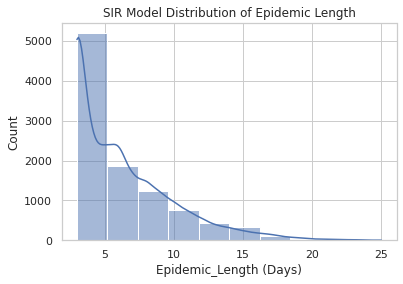

In [30]:
plot_SIR_distribution_epidemic_length(df10k)

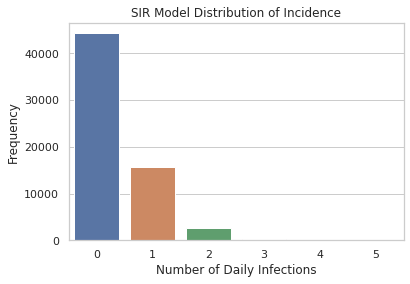

,Number of Daily Infections,Frequency,Percentage
0,0,44275,70.503838
1,1,15620,24.873404
2,2,2617,4.167330
3,3,261,0.415618
4,4,24,0.038218
5,5,1,0.001592


In [31]:
plot_SIR_distribution_incidence(dailyinfectionsfreqdf10k)
dailyinfectionsfreqdf10k

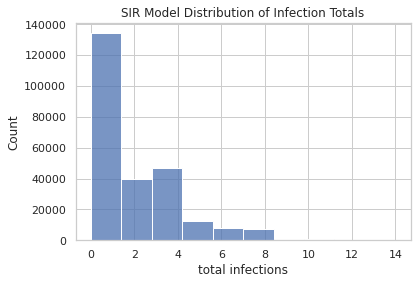

In [32]:
plot_SIR_distribution_infection_totals(longdf10k)

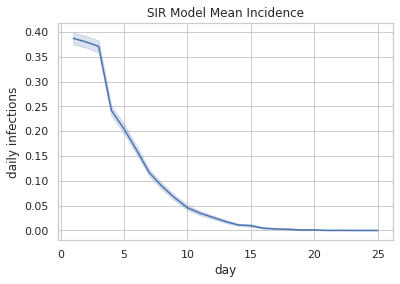

In [33]:
plot_lineplot_epidimiology(longdf10k, 
                           x="day", y="daily infections", 
                           title='SIR Model Mean Incidence')

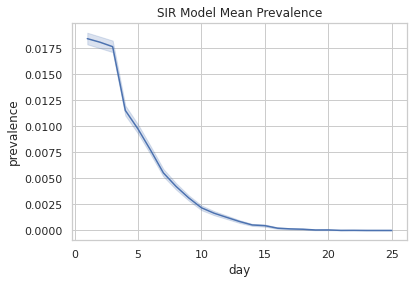

In [34]:
plot_lineplot_epidimiology(longdf10k, 
                           x="day", y="prevalence", 
                           title='SIR Model Mean Prevalence')

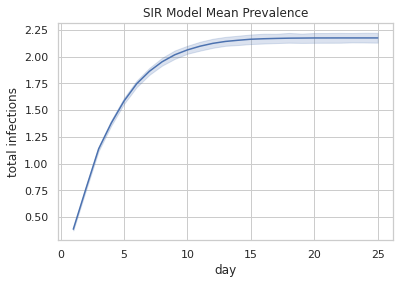

In [35]:
plot_lineplot_epidimiology(longdf10k, 
                           x="day", y="total infections", 
                           title='SIR Model Mean Prevalence')

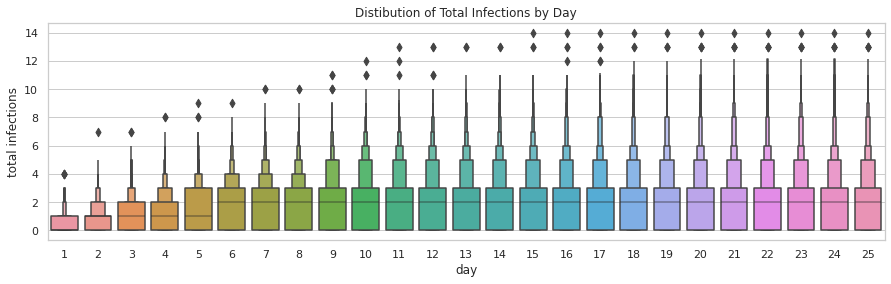

In [36]:
plot_distribution_total_infections_by_day(longdf10k)

In [37]:
sirdf10k

,simulation,day,variable,value
0,0,1,total infections,0
1,0,2,total infections,1
2,0,3,total infections,1
3,0,4,total infections,1
4,0,5,total infections,2
...,...,...,...,...
749995,9999,21,susceptible,21
749996,9999,22,susceptible,21
749997,9999,23,susceptible,21
749998,9999,24,susceptible,21


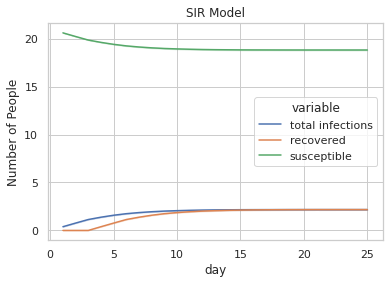

In [38]:
plot_SIR_timeseries(sirdf10k)

### Plotting each simulation

In [39]:
def plot_sim_daily_infections(df):
  """
  Plot simulations' daily infections

  Params:
    df: Pandas Dataframe of Simulations
  """
  plt = sns.lineplot(data = df, x = "day", y = "daily infections", 
                     hue = "simulation")
  plt.xaxis.set_major_locator(ticker.MultipleLocator(10))


def plot_sim_total_infections(df):
  """
  Plot simulations' total infections

  Params:
    df: Pandas Dataframe of Simulations
  """
  plt = sns.lineplot(data = df, x = "day", y = "total infections", 
                     hue = "simulation")
  plt.xaxis.set_major_locator(ticker.MultipleLocator(10))



In [40]:
experiment_100 = Experiment(100, 200, 0.02, 3)
_,_,longdf100,_,_,_ = epidimiological_experiment(
    100, 
    200, 
    0.02, 
    3
)

Total time elapsed to gather data for 100 trials: 0:00:00.395303




<ipython-input-25-c0882c9beaac>:87: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_df = long_df.groupby(['day'])['daily infections',


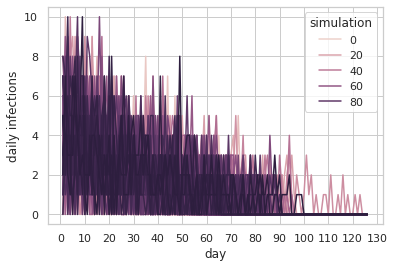

In [41]:
plot_sim_daily_infections(longdf100)

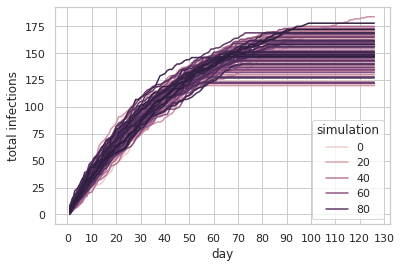

In [42]:
plot_sim_total_infections(longdf100)

## Additional Analysis
This section includes:

* Effect of varied infection probability
* Effect of varied infection length
* Effect of varied class size


In [43]:
import matplotlib.pyplot as plt
def coupled_experiments(params, epi_len, dfs, index, val):
  """
  Run a set of experiments and update epidemic lengths and dfs passed by ref.

  Params:
    params: tuple of parameters for Experiment.
    epi_len: Pandas dataframe of epidemic lengths.
    dfs: Dictionary of Pandas dataframes.
    index: integer index as key for entry into dfs.
    val: value of a variable which to assess its effects on.
  """
  expdf, daily_infection_freq_expdf = Experiment(*params).run_experiment()
  epi_len[str(val)] = expdf[["Epidemic_Length (Days)"]]
  dfs[index] = long(expdf, params[1])


def data_varying_infection_probs(infection_probs, num_trials, 
                                 pop_size, infection_period):
  """
  Visualize the effect of varying infection probabilities in epidemic.

  Params:
    infection_probs: list of infection probabilities.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes.
  """
  prob_dfs = {}
  epi_len = pd.DataFrame()
  for i,p in enumerate(infection_probs):
    coupled_experiments(
        (num_trials, pop_size, p, infection_period),
        epi_len,
        prob_dfs,
        i,
        p
    )
  epi_len.reset_index(inplace=True)
  epi_len = epi_len.rename(columns = {'index':'simulation'})
  epi_len = epi_len.melt(id_vars=['simulation'], 
                         var_name = "infection probability", 
                         value_name = "length of epidemic")
  return epi_len, prob_dfs


def data_varying_effect_infection_lengths(infection_lengths, num_trials, 
                                          pop_size, p_exposure):
  """
  Visualize the effect of varying infection length in epidemic.

  Params:
    infection_lengths: list of infection period lengths.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes.
  """
  #infection_lengths = [1,2,3,4,5]
  l_dfs = {}
  epi_len2 = pd.DataFrame()
  for i,l in enumerate(infection_lengths):
    coupled_experiments(
        (num_trials, pop_size, p_exposure, l),
        epi_len2,
        l_dfs,
        i,
        l
    )
  epi_len2.reset_index(inplace=True)
  epi_len2 = epi_len2.rename(columns = {'index':'simulation'})
  epi_len2 = epi_len2.melt(id_vars=['simulation'], 
                           var_name = "infection length", 
                           value_name = "length of epidemic")
  return epi_len2, l_dfs


def data_varying_effect_class_size(class_size, num_trials, p_exposure, 
                                   infection_period):
  """
  Visualize the effect of varying class size.

  Params:
    class_size: list of class size.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes
  """
  #class_size = [*range(10, 101, 10)]
  c_dfs = {}
  epi_len3 = pd.DataFrame()
  for i,c in enumerate(class_size):
    coupled_experiments(
        (num_trials, c, p_exposure, infection_period),
        epi_len3,
        c_dfs,
        i,
        c
    )
  epi_len3.reset_index(inplace=True)
  epi_len3 = epi_len3.rename(columns = {'index':'simulation'})
  epi_len3 = epi_len3.melt(id_vars=['simulation'], 
                           var_name = "class size", 
                           value_name = "length of epidemic")
  return epi_len3, c_dfs


def run_variation_analysis(num_trials, pop_size, p_exposure, infection_period):
  """
  Run experiments with one of the key parameters as a list.

  Params:
    num_trials: Must be an integer.
    pop_size: Can be either an integer or a list of integers.
    p_exposure: can be either a float or a list of floats.
    infection_period: can be either an integer or a list of integers.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes
  """
  if not isinstance(num_trials, int):
    raise ValueError("num_trials must be an integer!")
  if (isinstance(pop_size, list), 
      isinstance(p_exposure, (float, tuple)), 
      isinstance(infection_period, (int, tuple))) == (True, True, True):
      return data_varying_effect_class_size(
          pop_size, 
          num_trials, 
          p_exposure, 
          infection_period
      )
  if (isinstance(pop_size, int), 
      isinstance(p_exposure, list), 
      isinstance(infection_period, (int, tuple))) == (True, True, True):
      return data_varying_infection_probs(
          p_exposure, 
          num_trials, 
          pop_size,
          infection_period
      )
  if (isinstance(pop_size, int), 
      isinstance(p_exposure, (float, tuple)), 
      isinstance(infection_period, list)) == (True, True, True):
      return data_varying_effect_infection_lengths(
          infection_period, 
          num_trials,
          pop_size, 
          p_exposure
      )
  raise RuntimeError(
      "Check your inputs into this function and try again!"
      "Hint: num_trials must always be a int; as for the rest of the variables,"
      " only one of them can be a list!"
  )


def graph_against_epidemic_lengths(epi_len, x, hue_quantity, bins):
  """
  Graph against epidemic lengths.

  Params:
    epi_len: Pandas dataframe of epidemic lengths.
    x: x-axis label.
    hue_quantity: hue property which is also the quantity of interest.
    bins: Number of bins.
  """
  fig, ax =plt.subplots(1,2)
  sns.histplot(data = epi_len, x = x, hue = hue_quantity, bins = bins, ax=ax[0])
  sns.histplot(data = epi_len, x = x, hue = hue_quantity, 
               bins = bins, element = "poly", ax=ax[1])
  fig.set_size_inches(15, 4)
  fig.suptitle(f'Distibution of Epidemic Lengths by {hue_quantity}')


def graph_against_infection_counts(vals, dfs, x, y1, y2, 
                                   label, quantity, legend=None):
  """
  Graph against infection counts.

  Params:
    vals: list of values.
    dfs: Dictionary of Pandas dataframes.
    x: x-axis label.
    y1: y-axis label for first graph.
    y2: y-axis label for second graph.
    label: legend label.
    quantity: actual variable of interest.
    legend: Legend parameter; default to None as parameter is optional.
  """
  fig, ax = plt.subplots(1,2)
  for i,v in enumerate(vals):
    sns.lineplot(x = x, y = y1, data = dfs[i], 
                 label =f'{label} = {v}', ax=ax[0])
    sns.lineplot(x = x, y = y2, data = dfs[i], 
                 label =f'{label} = {v}', ax=ax[1])
  fig.set_size_inches(15, 4)
  fig.suptitle(f'Incidence and Total Infections by {quantity}')
  if legend:
    fig.legend(title = legend)

### Varied Infection probability
$N = 21$, $\text{infection period (days)} = 3$

In [44]:
p_exposures = [.01, .05, .1, .25, .5, .75]
epi_len1, prob_dfs = run_variation_analysis(10000, 21, p_exposures, 3)

Total time elapsed to gather data for 10000 trials: 0:00:01.517195


Total time elapsed to gather data for 10000 trials: 0:00:04.329841


Total time elapsed to gather data for 10000 trials: 0:00:06.616252


Total time elapsed to gather data for 10000 trials: 0:00:06.657873


Total time elapsed to gather data for 10000 trials: 0:00:06.037839


Total time elapsed to gather data for 10000 trials: 0:00:05.621107




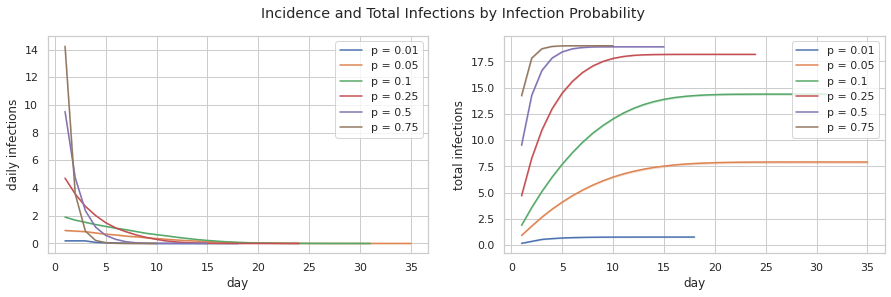

In [45]:
graph_against_infection_counts(p_exposures, 
                               prob_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'p',
                               'Infection Probability')
#plt.savefig('inf_prob.png')

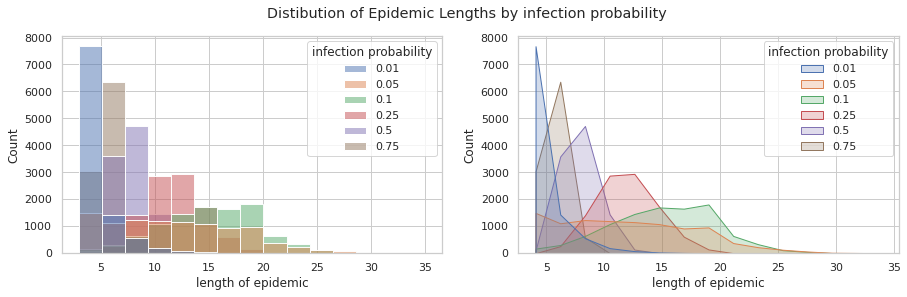

In [46]:
graph_against_epidemic_lengths(epi_len1,
                               "length of epidemic",
                               "infection probability",
                               15)
#plt.savefig('inf_prob_epi_len.png')

### Varied Infection Length

$N=21$, $p=0.02$

In [47]:
infection_periods = [1,2,3,4,5]
epi_len2, l_dfs = run_variation_analysis(10000, 21, 0.02, infection_periods)

Total time elapsed to gather data for 10000 trials: 0:00:00.573563


Total time elapsed to gather data for 10000 trials: 0:00:01.211092


Total time elapsed to gather data for 10000 trials: 0:00:02.056602


Total time elapsed to gather data for 10000 trials: 0:00:03.063569


Total time elapsed to gather data for 10000 trials: 0:00:04.226467




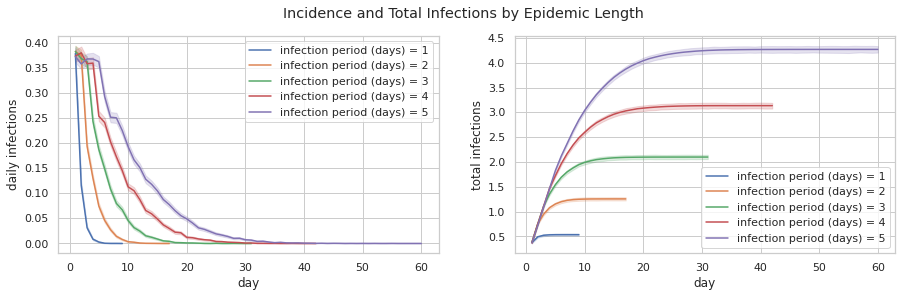

In [48]:
graph_against_infection_counts(infection_periods, 
                               l_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'infection period (days)',
                               'Epidemic Length')
#plt.savefig('inf_len.png')

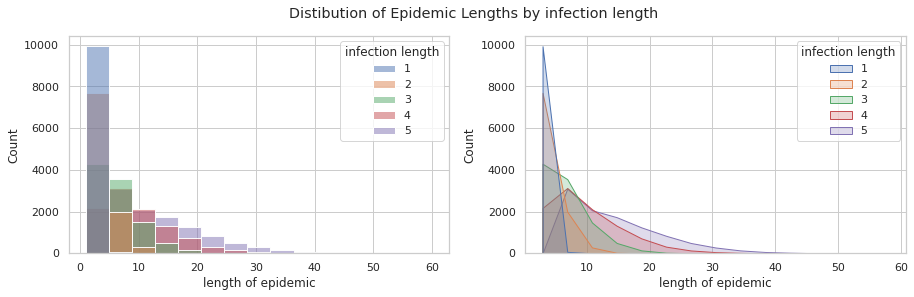

In [49]:
graph_against_epidemic_lengths(epi_len2,
                               "length of epidemic",
                               "infection length",
                               15)
#plt.savefig('inf_len_epi_len.png')

### Varied Class Size

$p=0.02$, $\text{infection period (days)} = 3$

In [50]:
pop_sizes = [*range(10, 101, 10)]
epi_len3, c_dfs = run_variation_analysis(10000, pop_sizes, 0.02, 3)

Total time elapsed to gather data for 10000 trials: 0:00:01.264583


Total time elapsed to gather data for 10000 trials: 0:00:02.021855


Total time elapsed to gather data for 10000 trials: 0:00:02.861565


Total time elapsed to gather data for 10000 trials: 0:00:04.239794


Total time elapsed to gather data for 10000 trials: 0:00:05.494088


Total time elapsed to gather data for 10000 trials: 0:00:06.910971


Total time elapsed to gather data for 10000 trials: 0:00:08.874142


Total time elapsed to gather data for 10000 trials: 0:00:12.131476


Total time elapsed to gather data for 10000 trials: 0:00:12.756960


Total time elapsed to gather data for 10000 trials: 0:00:14.835410




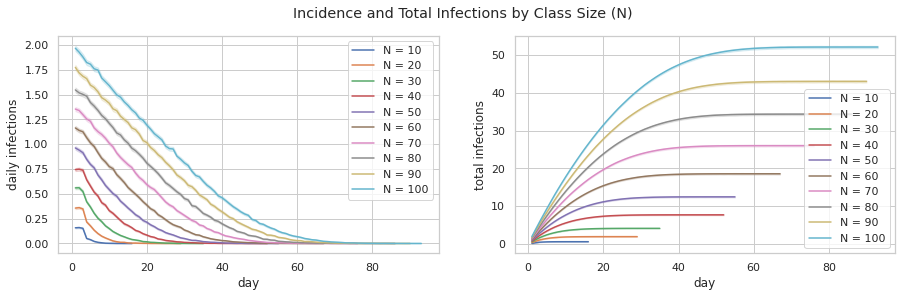

In [51]:
graph_against_infection_counts(pop_sizes, 
                               c_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'N',
                               "Class Size (N)")
#plt.savefig('class_size.png')

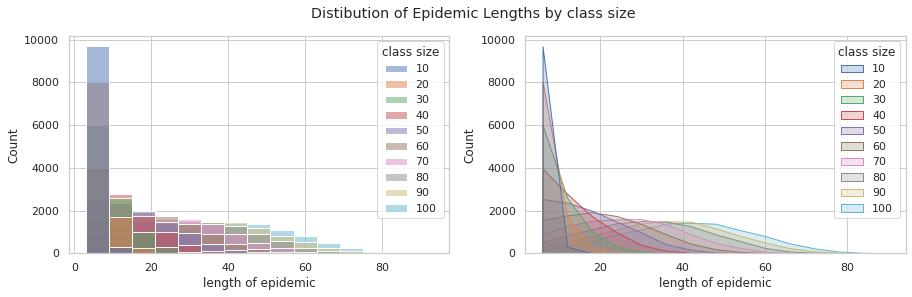

In [52]:
graph_against_epidemic_lengths(epi_len3,
                               "length of epidemic",
                               "class size",
                               15)
#plt.savefig('class_size_epi_len.png')

## Bonus Content on Future Work

### An Experiment involving Varying Infection Periods

In [53]:
bonus_experiment = Experiment(1000000, 21, 0.02, (3,7))
bonus_trial_df, bonus_infections_freq_df = bonus_experiment.run_experiment()
bonus_stats, bonus_groupby_epidemiclength, bonus_groupby_totalinfections = \
  basic_stats(bonus_trial_df, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:06:24.232195




In [54]:
bonus_trial_df

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D60,D61,D62,D63,D64,D65,D66,D67,Epidemic_Length (Days),Total_Infections
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
3,1,0,2,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,14,6
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
999996,0,1,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,31,14
999997,0,0,1,2,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,10,6
999998,0,1,1,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,15,7


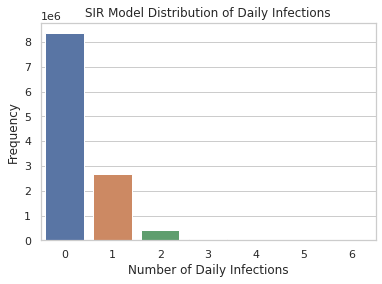

,Number of Daily Infections,Frequency,Percentage
0,0,8353179,72.731795
1,1,2671246,23.258752
2,2,415319,3.616216
3,3,41910,0.364914
4,4,3084,0.026853
5,5,165,0.001437
6,6,4,0.000035


In [55]:
sns.barplot(data = bonus_infections_freq_df,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
bonus_infections_freq_df

In [56]:
bonus_groupby_epidemiclength

Epidemic_Length (Days)
3     79140
4     65740
5     68409
6     83713
7     62937
8     61478
9     58410
10    54503
11    50877
12    47106
13    43406
14    39392
15    36123
16    32504
17    29304
18    25580
19    23258
20    20612
21    18054
22    15714
23    13670
24    11996
25    10232
26     8501
27     7060
28     6064
29     5068
30     4152
31     3588
32     2829
33     2312
34     1788
35     1424
36     1168
37      961
38      729
39      551
40      420
41      313
42      233
43      184
44      150
45      115
46       70
47       48
48       25
49       28
50       15
51       14
52        7
53        8
54        9
55        4
56        1
57        1
59        1
67        1
Name: Epidemic_Length (Days), dtype: int64

In [57]:
bonus_groupby_totalinfections

Total_Infections
1     194870
2     133974
3     119458
4     108021
5      96628
6      82999
7      69878
8      56487
9      44770
10     33357
11     23753
12     15722
13      9711
14      5634
15      2887
16      1202
17       475
18       140
19        31
20         3
Name: Total_Infections, dtype: int64

In [58]:
bonus_stats

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.380407,0.610803,0.0,0.0,0.0,1.0,5.0
D2,1000000.0,0.373872,0.605184,0.0,0.0,0.0,1.0,5.0
D3,1000000.0,0.364153,0.597828,0.0,0.0,0.0,1.0,6.0
D4,1000000.0,0.326720,0.574719,0.0,0.0,0.0,1.0,6.0
D5,1000000.0,0.295922,0.552252,0.0,0.0,0.0,1.0,5.0
...,...,...,...,...,...,...,...,...
D65,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
D66,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
D67,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Epidemic_Length (Days),1000000.0,11.484907,7.056281,3.0,6.0,10.0,15.0,67.0


### An Experiment involving Varying Infection Probabilities

In [59]:
bonus_experiment2 = Experiment(1000000, 21, (0.05,0.15), 3)
bonus_trial_df2, bonus_daily_infections_freq_df2 = bonus_experiment2.run_experiment()
bonus_stats2, bonus_groupby_epidemiclength2, bonus_groupby_totalinfections2 = \
  basic_stats(bonus_trial_df2, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:12:20.328357




In [60]:
bonus_trial_df2

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D29,D30,D31,D32,D33,D34,D35,D36,Epidemic_Length (Days),Total_Infections
0,3,2,2,1,1,2,1,1,1,0,...,0,0,0,0,0,0,0,0,16,17
1,1,3,0,1,3,0,0,2,0,1,...,0,0,0,0,0,0,0,0,19,18
2,2,4,0,4,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,10,15
3,3,3,1,1,3,0,1,2,1,1,...,0,0,0,0,0,0,0,0,13,17
4,1,3,2,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,10,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3,3,3,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,13
999996,1,1,2,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,24,16
999997,1,0,2,2,1,3,0,1,1,2,...,0,0,0,0,0,0,0,0,14,15
999998,2,5,0,3,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,15,16


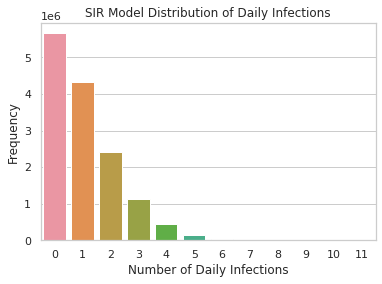

,Number of Daily Infections,Frequency,Percentage
0,0,5662707,40.017728
1,1,4317291,30.509821
2,2,2421228,17.110552
3,3,1124826,7.949022
4,4,435918,3.080585
5,5,140225,0.990955
6,6,37745,0.266740
7,7,8558,0.060478
8,8,1680,0.011872
9,9,279,0.001972


In [61]:
sns.barplot(data = bonus_daily_infections_freq_df2,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
bonus_daily_infections_freq_df2

In [62]:
bonus_groupby_epidemiclength2

Epidemic_Length (Days)
3       8707
4       2722
5       4034
6       7954
7      16065
8      28080
9      44522
10     62051
11     79150
12     92041
13    100023
14    101162
15     96678
16     87706
17     73314
18     59058
19     45026
20     32561
21     22659
22     14894
23      9232
24      5655
25      3215
26      1737
27       905
28       451
29       214
30       114
31        36
32        19
33         7
34         6
35         1
36         1
Name: Epidemic_Length (Days), dtype: int64

In [63]:
bonus_groupby_totalinfections2

Total_Infections
1       8707
2       1956
3       1450
4       1515
5       1781
6       2330
7       3459
8       5057
9       7861
10     12281
11     19049
12     29409
13     44340
14     65846
15     94732
16    129072
17    161857
18    176991
19    152790
20     79517
Name: Total_Infections, dtype: int64

In [64]:
bonus_stats2

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,1.902330,1.412453,0.0,1.0,2.0,3.0,11.0
D2,1000000.0,1.992497,1.384239,0.0,1.0,2.0,3.0,11.0
D3,1000000.0,1.905395,1.323808,0.0,1.0,2.0,3.0,10.0
D4,1000000.0,1.698656,1.259893,0.0,1.0,2.0,2.0,10.0
D5,1000000.0,1.475543,1.184929,0.0,1.0,1.0,2.0,10.0
D6,1000000.0,1.265843,1.108698,0.0,0.0,1.0,2.0,9.0
D7,1000000.0,1.068595,1.031019,0.0,0.0,1.0,2.0,8.0
D8,1000000.0,0.896062,0.953385,0.0,0.0,1.0,1.0,8.0
D9,1000000.0,0.739140,0.879320,0.0,0.0,1.0,1.0,10.0
D10,1000000.0,0.600134,0.802085,0.0,0.0,0.0,1.0,7.0


### An Experiment involving both Varying Infection Probabilities and Periods

In [65]:
bonus_experiment3 = Experiment(1000000, 21, (0.05,0.15), (3,7))
bonus_trial_df3, bonus_daily_infections_freq_df3 = bonus_experiment3.run_experiment()
bonus_stats3, bonus_groupby_epidemiclength3, bonus_groupby_totalinfections3 = \
  basic_stats(bonus_trial_df3, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:17:50.287537




In [66]:
bonus_trial_df3

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D39,D40,D41,D42,D43,D44,D45,D46,Epidemic_Length (Days),Total_Infections
0,2,3,3,2,1,2,2,0,2,0,...,0,0,0,0,0,0,0,0,16,19
1,1,2,3,3,0,1,2,2,0,1,...,0,0,0,0,0,0,0,0,17,20
2,4,1,2,3,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,18,18
3,6,2,0,1,2,2,0,0,0,1,...,0,0,0,0,0,0,0,0,20,19
4,1,2,1,3,5,2,0,0,0,1,...,0,0,0,0,0,0,0,0,15,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,4,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,32,20
999996,1,2,2,5,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,17,18
999997,3,2,1,2,2,1,2,0,0,1,...,0,0,0,0,0,0,0,0,22,20
999998,3,2,2,2,0,3,2,0,1,0,...,0,0,0,0,0,0,0,0,13,16


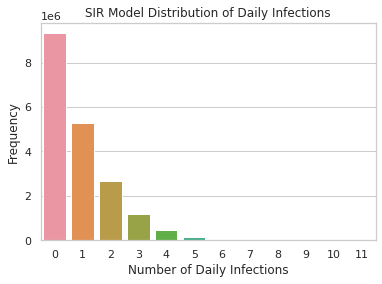

,Number of Daily Infections,Frequency,Percentage
0,0,9323982,48.723351
1,1,5298043,27.685425
2,2,2667117,13.937272
3,3,1197131,6.255721
4,4,454763,2.376407
5,5,145743,0.761594
6,6,38961,0.203594
7,7,8789,0.045928
8,8,1733,0.009056
9,9,275,0.001437


In [67]:
sns.barplot(data = bonus_daily_infections_freq_df3,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
bonus_daily_infections_freq_df3

In [68]:
bonus_groupby_epidemiclength3

Epidemic_Length (Days)
3      2199
4       849
5       443
6       329
7       469
8      1206
9      3225
10     7645
11    15013
12    26040
13    38938
14    53487
15    66905
16    78188
17    85198
18    88182
19    87094
20    82145
21    74711
22    65007
23    54411
24    44522
25    35091
26    26594
27    19590
28    14290
29     9630
30     6767
31     4568
32     2893
33     1794
34     1085
35      650
36      386
37      191
38      130
39       60
40       45
41       13
42       10
43        4
44        1
45        1
46        1
Name: Epidemic_Length (Days), dtype: int64

In [69]:
bonus_groupby_totalinfections3

Total_Infections
1       3090
2        485
3        199
4        142
5        143
6        155
7        281
8        440
9        841
10      1403
11      2819
12      5333
13     10534
14     20234
15     38907
16     71717
17    126832
18    204061
19    273698
20    238686
Name: Total_Infections, dtype: int64

In [70]:
bonus_stats3

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,1.900959,1.413109,0.0,1.0,2.0,3.0,11.0
D2,1000000.0,1.992747,1.385558,0.0,1.0,2.0,3.0,11.0
D3,1000000.0,1.904929,1.324618,0.0,1.0,2.0,3.0,11.0
D4,1000000.0,1.730033,1.262391,0.0,1.0,2.0,2.0,9.0
D5,1000000.0,1.533804,1.194574,0.0,1.0,1.0,2.0,9.0
D6,1000000.0,1.337521,1.124067,0.0,0.0,1.0,2.0,9.0
D7,1000000.0,1.152695,1.049903,0.0,0.0,1.0,2.0,9.0
D8,1000000.0,0.988581,0.979020,0.0,0.0,1.0,2.0,8.0
D9,1000000.0,0.842228,0.908806,0.0,0.0,1.0,1.0,9.0
D10,1000000.0,0.715088,0.841533,0.0,0.0,1.0,1.0,8.0


## Data Visualizations for Dynamic Infection Probabilities and Periods

In [71]:
b_epidim_10k = epidimiological_experiment(10000, 21, (0.05,0.15), (3,7))
b_df10k, \
b_dailyinfectionsfreqdf10k, \
b_longdf10k, \
b_statsdf10k, \
b_meandf10k, \
b_sirdf10k = epidim_10k

Total time elapsed to gather data for 10000 trials: 0:00:10.560238




<ipython-input-25-c0882c9beaac>:87: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_df = long_df.groupby(['day'])['daily infections',


In [72]:
b_longdf10k

,simulation,day,daily infections,total infections,recovered,susceptible,prevalence
0,0,1,0,0,0,21,0.000000
10000,0,2,1,1,0,20,0.047619
20000,0,3,0,1,0,20,0.000000
30000,0,4,0,1,0,20,0.000000
40000,0,5,1,2,1,19,0.047619
...,...,...,...,...,...,...,...
209999,9999,21,0,0,0,21,0.000000
219999,9999,22,0,0,0,21,0.000000
229999,9999,23,0,0,0,21,0.000000
239999,9999,24,0,0,0,21,0.000000


In [73]:
b_statsdf10k

,daily infections,total infections,recovered,susceptible,prevalence,Epidemic_Length (Days)
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,10000.000000
mean,0.086952,1.891524,1.630668,19.108476,0.004141,6.279800
std,0.328365,2.042796,1.974393,2.042796,0.015636,3.597611
min,0.000000,0.000000,0.000000,7.000000,0.000000,3.000000
25%,0.000000,0.000000,0.000000,18.000000,0.000000,3.000000
50%,0.000000,1.000000,1.000000,20.000000,0.000000,5.000000
75%,0.000000,3.000000,3.000000,21.000000,0.000000,8.000000
max,5.000000,14.000000,14.000000,21.000000,0.238095,25.000000


In [74]:
b_meandf10k

,daily infections,total infections,recovered,susceptible,prevalence
day,,,,,
1,0.3870,0.3870,0.0000,20.6130,0.018429
2,0.3798,0.7668,0.0000,20.2332,0.018086
3,0.3708,1.1376,0.0000,19.8624,0.017657
4,0.2421,1.3797,0.3870,19.6203,0.011529
5,0.2046,1.5843,0.7668,19.4157,0.009743
6,0.1615,1.7458,1.1376,19.2542,0.007690
7,0.1161,1.8619,1.3797,19.1381,0.005529
8,0.0888,1.9507,1.5843,19.0493,0.004229
9,0.0656,2.0163,1.7458,18.9837,0.003124


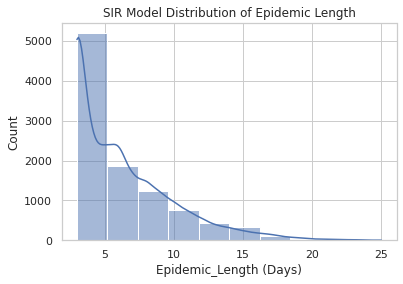

In [75]:
plot_SIR_distribution_epidemic_length(b_df10k)

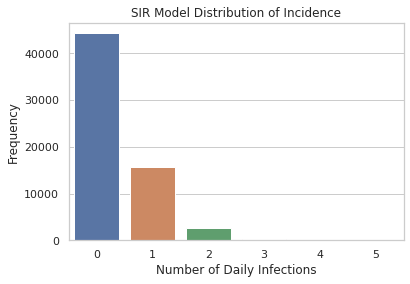

,Number of Daily Infections,Frequency,Percentage
0,0,44275,70.503838
1,1,15620,24.873404
2,2,2617,4.167330
3,3,261,0.415618
4,4,24,0.038218
5,5,1,0.001592


In [76]:
plot_SIR_distribution_incidence(b_dailyinfectionsfreqdf10k)
b_dailyinfectionsfreqdf10k

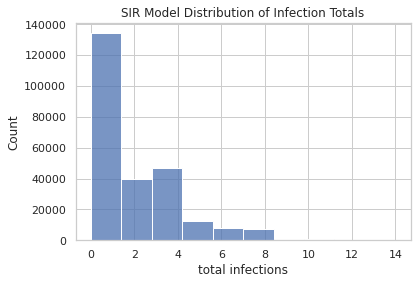

In [77]:
plot_SIR_distribution_infection_totals(b_longdf10k)

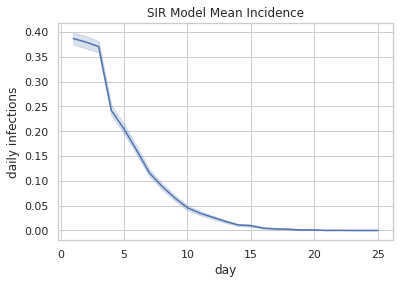

In [78]:
plot_lineplot_epidimiology(b_longdf10k, 
                           x="day", y="daily infections", 
                           title='SIR Model Mean Incidence')

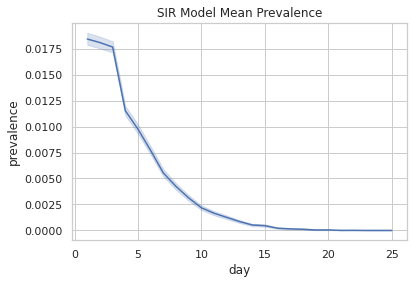

In [79]:
plot_lineplot_epidimiology(b_longdf10k, 
                           x="day", y="prevalence", 
                           title='SIR Model Mean Prevalence')

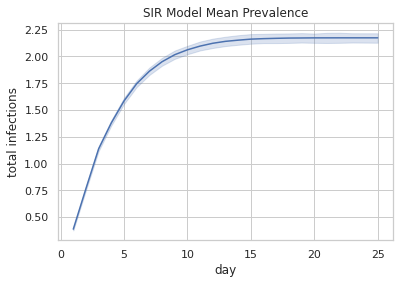

In [80]:
plot_lineplot_epidimiology(b_longdf10k, 
                           x="day", y="total infections", 
                           title='SIR Model Mean Prevalence')

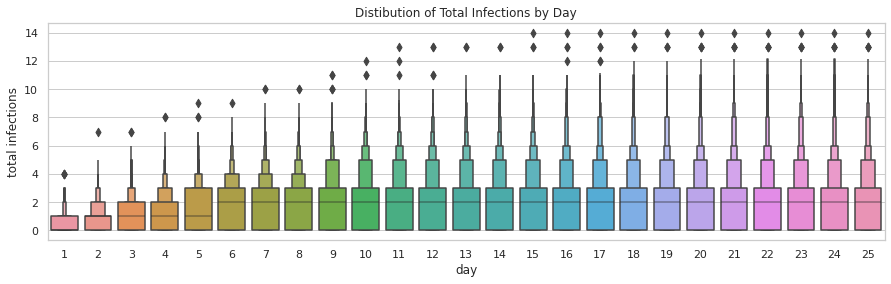

In [81]:
plot_distribution_total_infections_by_day(b_longdf10k)

In [82]:
b_sirdf10k

,simulation,day,variable,value
0,0,1,total infections,0
1,0,2,total infections,1
2,0,3,total infections,1
3,0,4,total infections,1
4,0,5,total infections,2
...,...,...,...,...
749995,9999,21,susceptible,21
749996,9999,22,susceptible,21
749997,9999,23,susceptible,21
749998,9999,24,susceptible,21


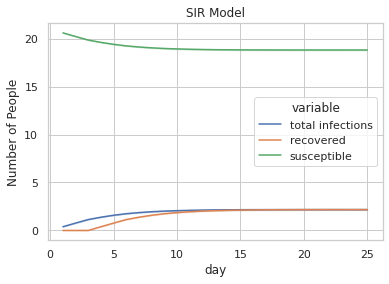

In [83]:
plot_SIR_timeseries(b_sirdf10k)

### Plotting each simulation with dynamic infection probabilities and periods in mind

In [84]:
_,_,b_longdf100,_,_,_ = epidimiological_experiment(
    100, 
    200, 
    (0.05,0.15), 
    (3,7)
)

Total time elapsed to gather data for 100 trials: 0:00:00.676161




<ipython-input-25-c0882c9beaac>:87: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_df = long_df.groupby(['day'])['daily infections',


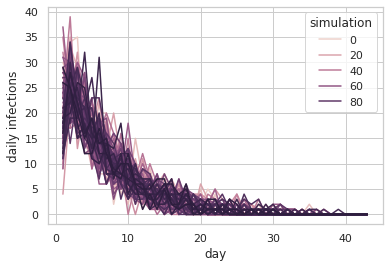

In [85]:
plot_sim_daily_infections(b_longdf100)

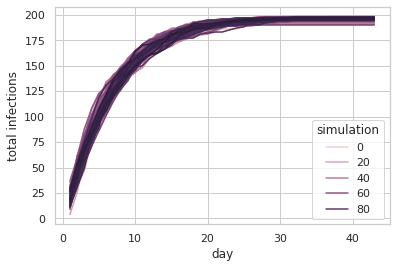

In [86]:
plot_sim_total_infections(b_longdf100)

### Varied Infection probability with dynamic infection periods
$N = 21$, $\text{infection period (days)} \in [3,7)$

In [87]:
p_exposures = [.01, .05, .1, .25, .5, .75]
b_epi_len1, b_prob_dfs = run_variation_analysis(10000, 21, p_exposures, (3,7))

Total time elapsed to gather data for 10000 trials: 0:00:02.613378


Total time elapsed to gather data for 10000 trials: 0:00:07.656899


Total time elapsed to gather data for 10000 trials: 0:00:09.679347


Total time elapsed to gather data for 10000 trials: 0:00:08.940759


Total time elapsed to gather data for 10000 trials: 0:00:07.928067


Total time elapsed to gather data for 10000 trials: 0:00:07.195213




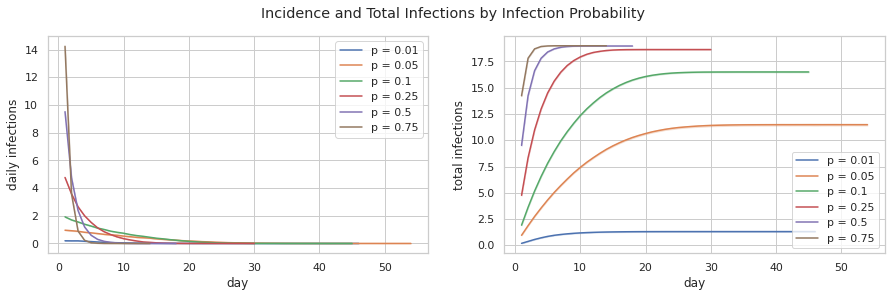

In [88]:
graph_against_infection_counts(p_exposures, 
                               b_prob_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'p',
                               'Infection Probability')
#plt.savefig('inf_prob.png')

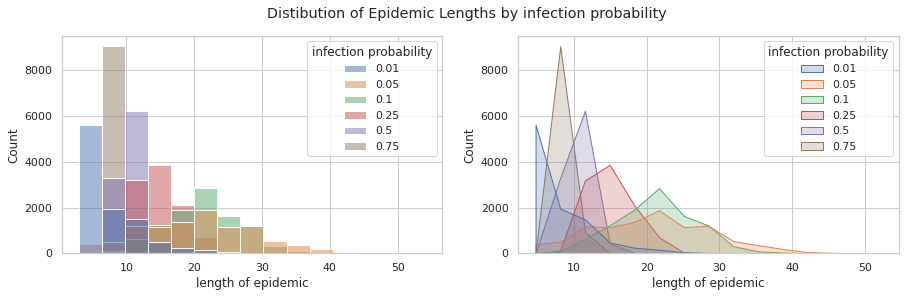

In [89]:
graph_against_epidemic_lengths(b_epi_len1,
                               "length of epidemic",
                               "infection probability",
                               15)
#plt.savefig('inf_prob_epi_len.png')

### Varied Infection Length with Dynamic Infection Probabilities

$N=21$, $p \in(0.05,0.15)$

In [90]:
infection_periods = [1,2,3,4,5]
b_epi_len2, b_l_dfs = run_variation_analysis(10000, 21, (0.05,0.15),
                                             infection_periods)

Total time elapsed to gather data for 10000 trials: 0:00:02.532369


Total time elapsed to gather data for 10000 trials: 0:00:05.507217


Total time elapsed to gather data for 10000 trials: 0:00:07.347415


Total time elapsed to gather data for 10000 trials: 0:00:08.859500


Total time elapsed to gather data for 10000 trials: 0:00:10.537838




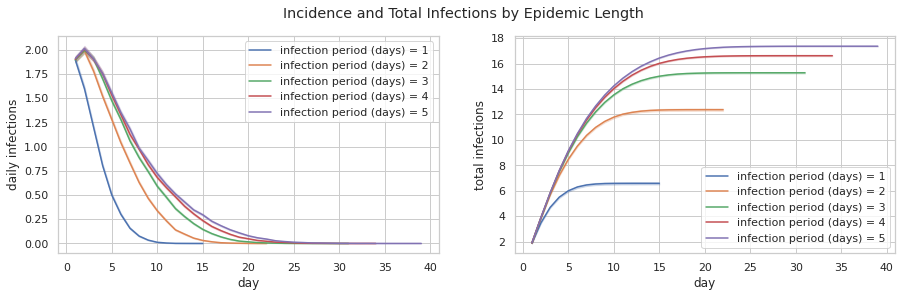

In [91]:
graph_against_infection_counts(infection_periods, 
                               b_l_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'infection period (days)',
                               'Epidemic Length')
#plt.savefig('inf_len.png')

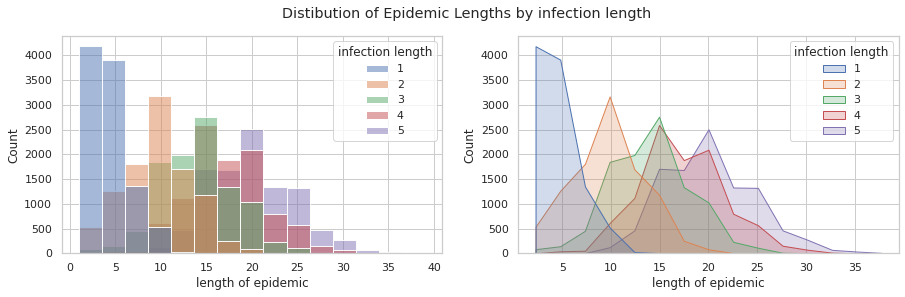

In [92]:
graph_against_epidemic_lengths(b_epi_len2,
                               "length of epidemic",
                               "infection length",
                               15)
#plt.savefig('inf_len_epi_len.png')

### Varied Class Size with Dynamic Infection Periods and Probabilities

$p \in (0.05,0.15)$, $\text{infection period (days)} \in [3,7)$

In [93]:
pop_sizes = [*range(10, 101, 10)]
b_epi_len3, b_c_dfs = run_variation_analysis(10000, pop_sizes, 
                                             (0.05,0.15), (3,7))

Total time elapsed to gather data for 10000 trials: 0:00:05.882526


Total time elapsed to gather data for 10000 trials: 0:00:09.933215


Total time elapsed to gather data for 10000 trials: 0:00:14.439866


Total time elapsed to gather data for 10000 trials: 0:00:17.861339


Total time elapsed to gather data for 10000 trials: 0:00:21.105151


Total time elapsed to gather data for 10000 trials: 0:00:24.181584


Total time elapsed to gather data for 10000 trials: 0:00:29.559747


Total time elapsed to gather data for 10000 trials: 0:00:29.556939


Total time elapsed to gather data for 10000 trials: 0:00:32.436870


Total time elapsed to gather data for 10000 trials: 0:00:36.113833




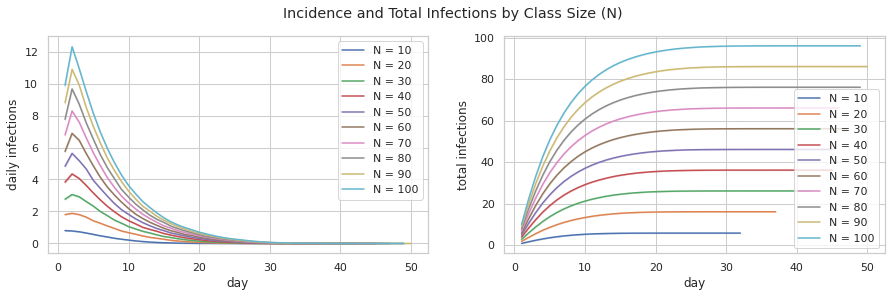

In [94]:
graph_against_infection_counts(pop_sizes, 
                               b_c_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'N',
                               "Class Size (N)")
#plt.savefig('class_size.png')

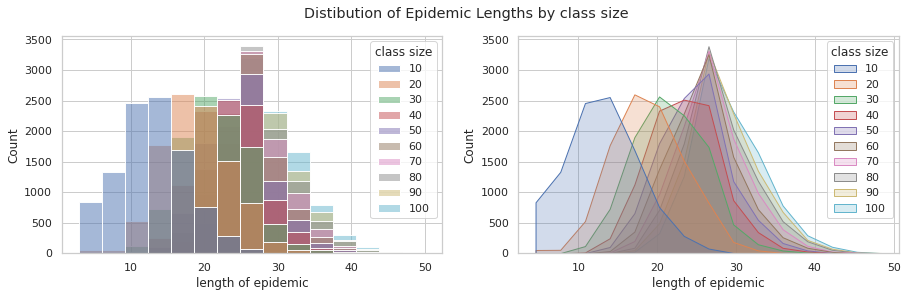

In [95]:
graph_against_epidemic_lengths(b_epi_len3,
                               "length of epidemic",
                               "class size",
                               15)
#plt.savefig('class_size_epi_len.png')